## **MMCCI Aging Brain Integration and Analysis Example**

In this example, we have young and aged Visium and STOmics mouse brain samples.
Each sample has been run through stLearn CCI and the outputs are saved as `.h5ad` files.

We will integrate the samples together, and then run analysis on the integrated results.

### **Integration**

These CCI results will be integrated together in this notebook with the following steps:
1. Load the stLearn outputs and convert to be used with MMCCI
2. Integrate within technologies for aged and young
3. Integrate between technologies for aged and young

\
Note: This notebook took <10 mins to run and used <16GB of memory

In [22]:
import multimodal_cci as mmcci

#### 1. Load stLearn outputs

This data is available on the GitHub repo and includes the `adata.uns['per_lr_cci_cell_type]` for each sample, as well as the number of spots for each sample

In [2]:
import pickle

with open('../data/brain_data.pkl', 'rb') as f:
    brain_data = pickle.load(f)

In [3]:
# These colours will be used for plotting later

from matplotlib import pyplot as plt

colors = {
    'Ependymal': plt.colormaps.get_cmap('tab10').colors[0],
    'Astrocytes': plt.colormaps.get_cmap('tab10').colors[1],
    'Vascular': plt.colormaps.get_cmap('tab10').colors[2],
    'Oligos': plt.colormaps.get_cmap('tab10').colors[3],
    'Neurons': plt.colormaps.get_cmap('tab10').colors[4],
    'Microglia': plt.colormaps.get_cmap('tab10').colors[5],
    'Immune': plt.colormaps.get_cmap('tab10').colors[6],
    'PeripheralGlia': plt.colormaps.get_cmap('tab10').colors[7],
}

#### 2. Integrate within technologies

This step first normalises the samples based on the number of spots, then it integrates the LR matrices together per LR pair

In [4]:
brain_aged_tech1_normalised = mmcci.it.normalise_within_tech(brain_data['brain_aged_tech1_cci'], brain_data['brain_aged_tech1_sizes'])
brain_young_tech1_normalised = mmcci.it.normalise_within_tech(brain_data['brain_young_tech1_cci'], brain_data['brain_young_tech1_sizes'])
brain_aged_tech2_normalised = mmcci.it.normalise_within_tech(brain_data['brain_aged_tech2_cci'], brain_data['brain_aged_tech2_sizes'])
brain_young_tech2_normalised = mmcci.it.normalise_within_tech(brain_data['brain_young_tech2_cci'], brain_data['brain_young_tech2_sizes'])

brain_aged_tech1_integrated = mmcci.it.integrate_samples(brain_aged_tech1_normalised, method=">=50%", strict=True)
brain_young_tech1_integrated = mmcci.it.integrate_samples(brain_young_tech1_normalised, method=">=50%", strict=True)
brain_aged_tech2_integrated = mmcci.it.integrate_samples(brain_aged_tech2_normalised, method=">=50%", strict=True)
brain_young_tech2_integrated = mmcci.it.integrate_samples(brain_young_tech2_normalised, method=">=50%", strict=True)

Integrating LR matrices: 100%|██████████| 1253/1253 [00:01<00:00, 988.40it/s] 


The next step involves integrating the p-values together

In [5]:
brain_aged_tech1_pvals = mmcci.it.integrate_p_vals(brain_data['brain_aged_tech1_pvals'])
brain_young_tech1_pvals = mmcci.it.integrate_p_vals(brain_data['brain_young_tech1_pvals'])
brain_aged_tech2_pvals = mmcci.it.integrate_p_vals(brain_data['brain_aged_tech2_pvals'])
brain_young_tech2_pvals = mmcci.it.integrate_p_vals(brain_data['brain_young_tech2_pvals'])

Integrating p values: 100%|██████████| 1253/1253 [00:17<00:00, 72.12it/s]


Then we remove the statistically insignificant interactions

In [6]:
brain_aged_tech1_integrated_filtered = mmcci.it.remove_insignificant(brain_aged_tech1_integrated, brain_aged_tech1_pvals)
brain_young_tech1_integrated_filtered = mmcci.it.remove_insignificant(brain_young_tech1_integrated, brain_young_tech1_pvals)
brain_aged_tech2_integrated_filtered = mmcci.it.remove_insignificant(brain_aged_tech2_integrated, brain_aged_tech2_pvals)
brain_young_tech2_integrated_filtered = mmcci.it.remove_insignificant(brain_young_tech2_integrated, brain_young_tech2_pvals)

#### 3. Integrate between technologies

This step first normalises the samples based on the number of interactions, then it integrates the LR matrices together per LR pair

In [7]:
aged_normalised = mmcci.it.normalise_between_tech([brain_aged_tech1_integrated, brain_aged_tech2_integrated])
young_normalised = mmcci.it.normalise_between_tech([brain_young_tech1_integrated, brain_young_tech2_integrated])

aged_integrated = mmcci.it.integrate_samples(aged_normalised, method=">50%", strict=True)
young_integrated = mmcci.it.integrate_samples(young_normalised, method=">50%", strict=True)

Integrating LR matrices: 100%|██████████| 718/718 [00:00<00:00, 1294.08it/s]


Again, we integrate the p-values, this time across all the samples. Then we remove the insignificant interactions

In [8]:
aged_pvals = mmcci.it.integrate_p_vals(brain_data['brain_aged_tech1_pvals'] + brain_data['brain_aged_tech2_pvals'])
young_pvals = mmcci.it.integrate_p_vals(brain_data['brain_young_tech1_pvals'] + brain_data['brain_young_tech2_pvals'])

aged_integrated_filtered = mmcci.it.remove_insignificant(aged_integrated, aged_pvals)
young_integrated_filtered = mmcci.it.remove_insignificant(young_integrated, young_pvals)

Integrating p values: 100%|██████████| 1294/1294 [00:20<00:00, 64.21it/s]


Now we can visualise our integrated samples, either as network plots or chord plots

In [9]:
aged_overall = mmcci.it.calculate_overall_interactions(aged_integrated_filtered)
young_overall = mmcci.it.calculate_overall_interactions(young_integrated_filtered)

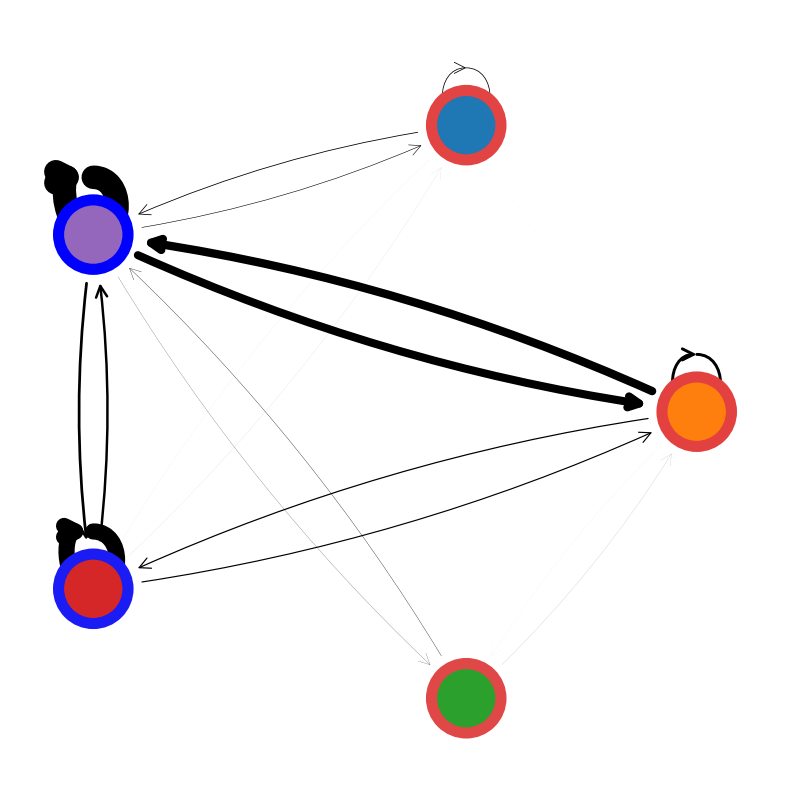

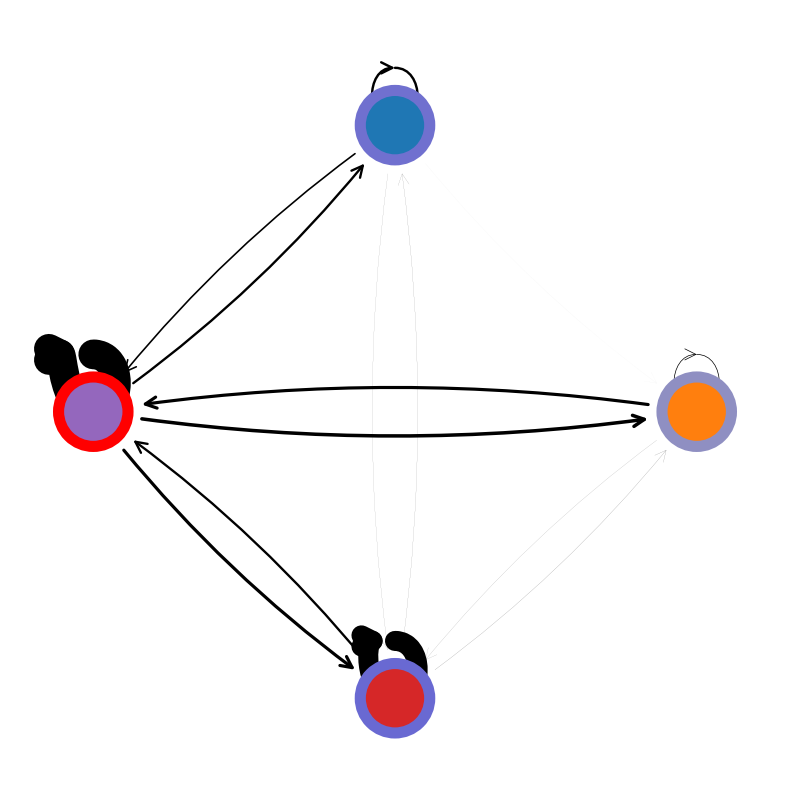

In [10]:
# Network plots
mmcci.plt.network_plot(aged_overall, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, show_labels=False)
mmcci.plt.network_plot(young_overall, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, show_labels=False)

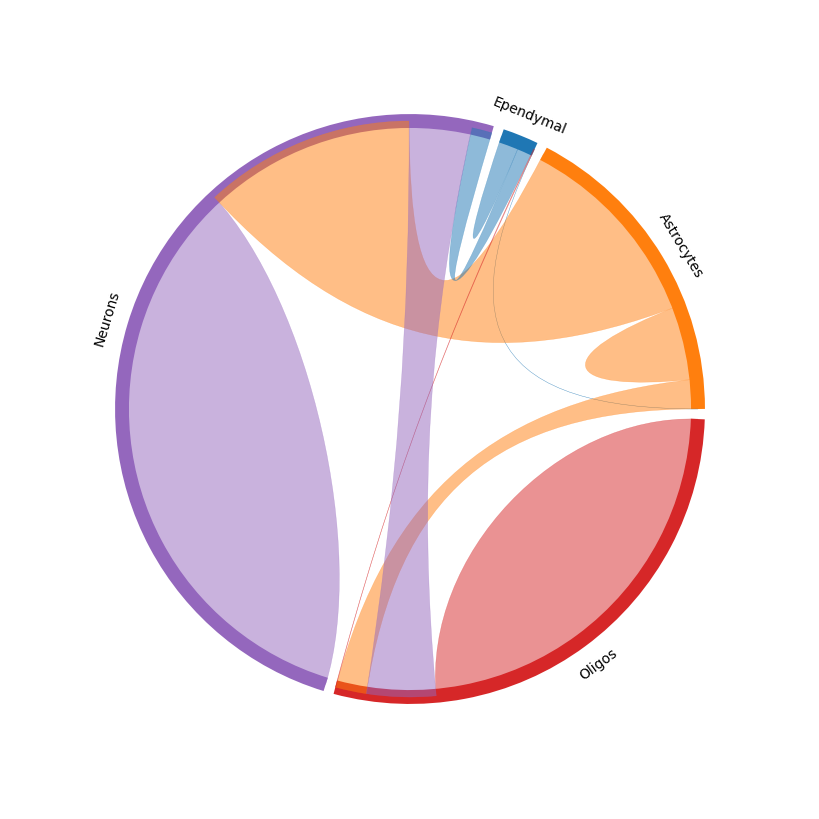

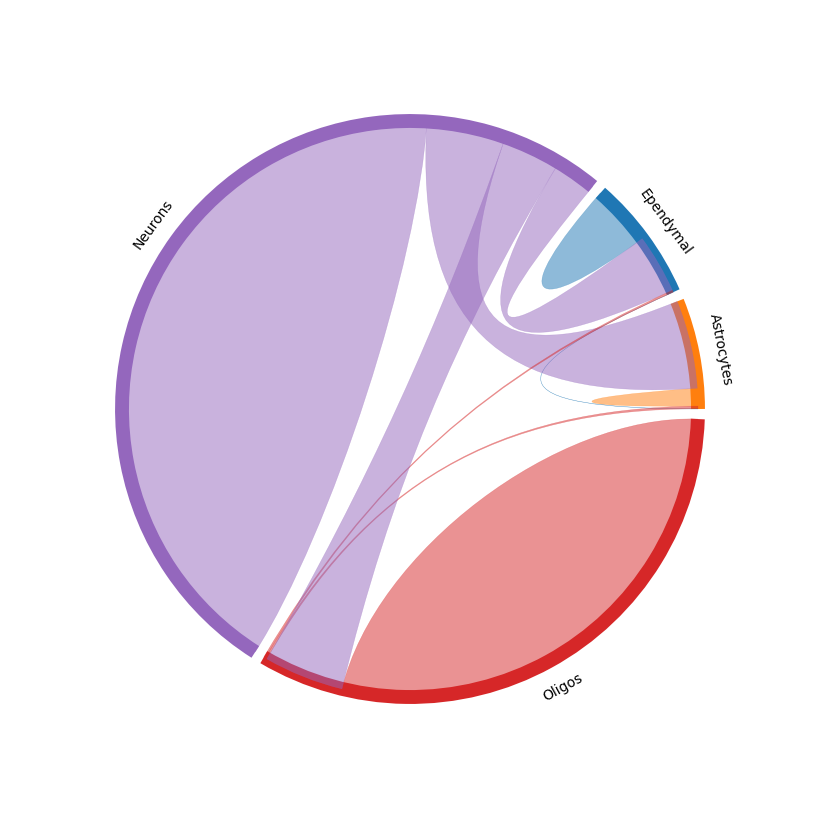

In [11]:
# Chord plots
mmcci.plt.chord_plot(aged_overall, colors=colors)
mmcci.plt.chord_plot(young_overall, colors=colors)

## **Analysis**

Now there are many analyses we can run on our integrated samples such as:
1. Get a difference plot between groups with permutation testing
2. Find dissimilar LR pairs
3. Query network edges for LR pairs
4. LR network clustering
5. Pathway clustering
6. LR interaction clustering

#### 1. Calculate p values for significance changes between aged and young overall networks

In [12]:
p_values = mmcci.an.perm_test(aged_overall, young_overall)
p_values

,Astrocytes,Ependymal,Immune,Microglia,Neurons,Oligos,PeripheralGlia,Vascular
Astrocytes,0.06250,0.29823,0.29763,0.29773,0.01550,0.10855,0.29673,0.26577
Ependymal,0.28031,0.09492,0.29429,0.29367,0.14063,0.23534,0.29557,0.29691
Immune,0.29757,0.29742,0.29736,0.29708,0.29728,0.29731,0.29793,0.29780
Microglia,0.29711,0.29532,0.29792,0.29697,0.29806,0.29811,0.29674,0.29833
Neurons,0.03103,0.07836,0.29623,0.29671,0.00000,0.15572,0.29665,0.18926
Oligos,0.12459,0.24966,0.29711,0.29722,0.20433,0.04694,0.29714,0.29536
PeripheralGlia,0.29917,0.29652,0.29782,0.29580,0.29688,0.29746,0.29671,0.29615
Vascular,0.21784,0.29572,0.29821,0.29757,0.17346,0.29789,0.29714,0.29502


Now we can plot the difference plot. \
\
Purple edges are significantly increased in aged and green are significantly increased in young

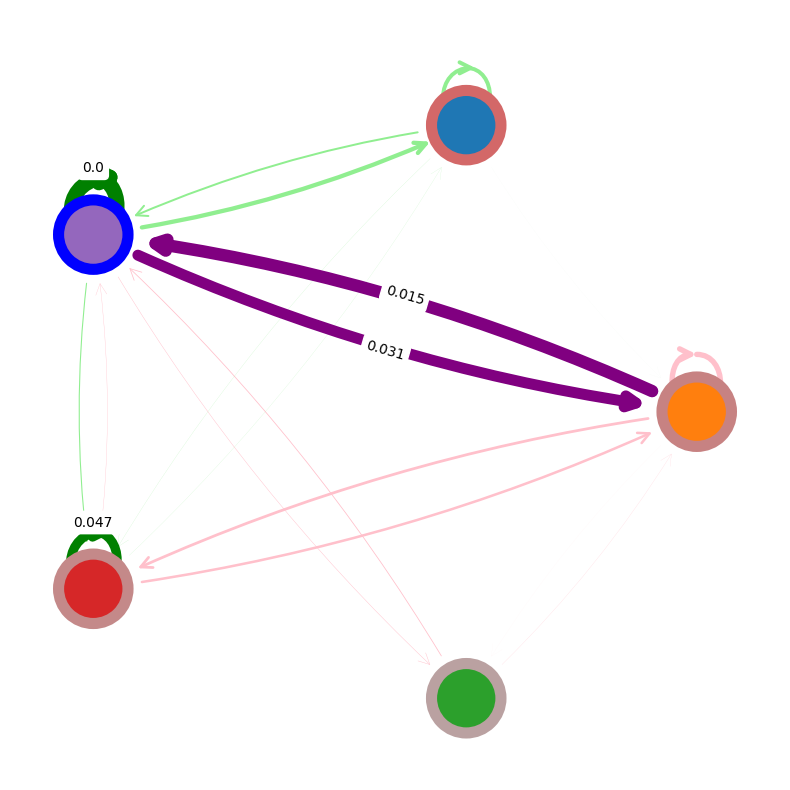

In [13]:
age_diff = mmcci.an.get_network_diff(aged_overall, young_overall)
mmcci.plt.network_plot(age_diff, p_values, diff_plot=True, show_labels=False, node_size=2500, edge_weight=120, figsize=(8,8), node_colors=colors)

#### 2. Find LR pairs with dissimilar networks between aged and young 

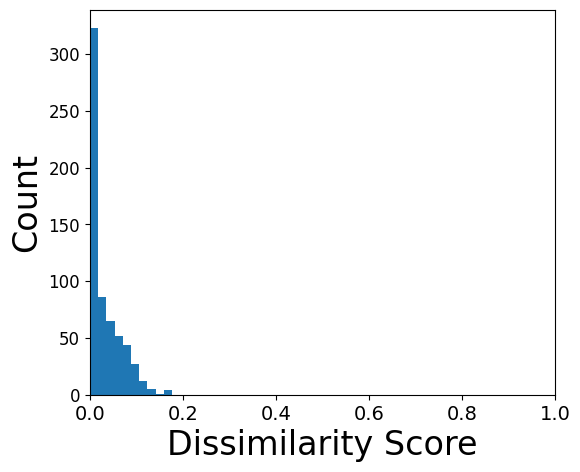

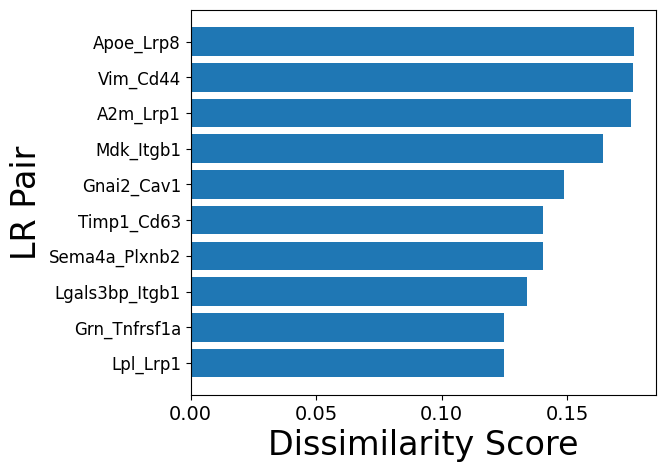

In [15]:
# Calculate dissimilarity score between aged and young for every LR pair 
dissimilarity_scores = mmcci.an.calculate_dissim(aged_integrated_filtered, young_integrated_filtered)

# Plot a histogram of these scores to see how much the LR networks change
mmcci.plt.dissim_hist(dissimilarity_scores)

# Show the most dissimilar LR pairs
mmcci.plt.lr_top_dissimilarity(dissimilarity_scores)

We can plot the most dissimilar LR pair to see how it changes. \
\
We can run a permutation test between the groups and plot the difference plot. \
The purple edges are more present in aged and the green edges are more present in young.

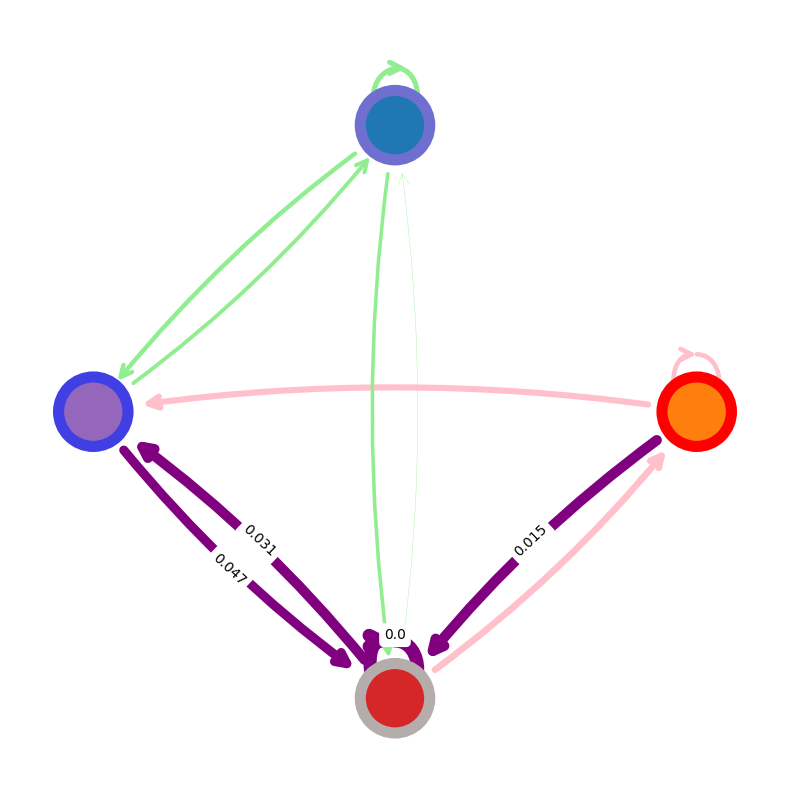

In [17]:
age_diff = mmcci.an.get_network_diff(aged_integrated_filtered['Vim_Cd44'], young_integrated_filtered['Vim_Cd44'])
p_values = mmcci.an.perm_test(aged_integrated_filtered['Vim_Cd44'], young_integrated_filtered['Vim_Cd44'])
mmcci.plt.network_plot(age_diff, p_values, diff_plot=True, show_labels=False, node_size=2500, edge_weight=0.1, figsize=(8,8), node_colors=colors)

#### 3. Get LR pairs from a sender (Astrocytes) and reciever (Neurons) cell type pair

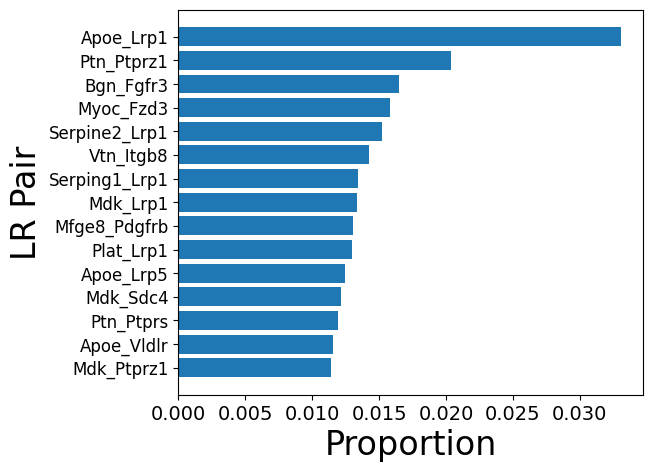

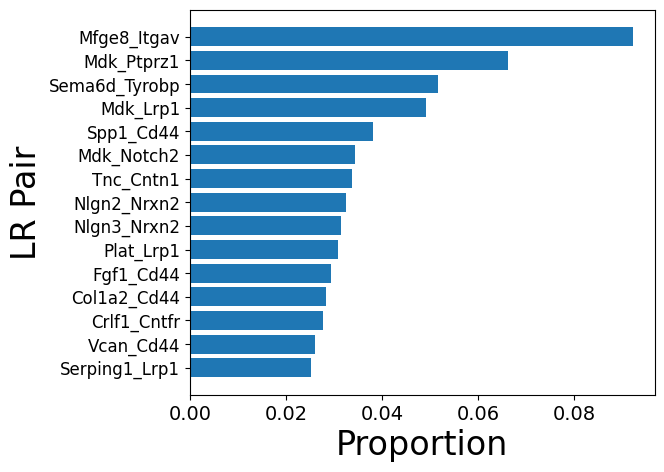

In [18]:
# Aged
mmcci.plt.lrs_per_celltype(aged_integrated_filtered, sender="Astrocytes", receiver="Neurons")

# Young
mmcci.plt.lrs_per_celltype(young_integrated_filtered, sender="Astrocytes", receiver="Neurons")

#### 4. Run LR network clustering

This analysis clusters LR pairs with similar networks together. \
Here we show an example of one aged cluster and one young cluster and run GSEA analysis on the LRs involved

Computing Dissimilarity Scores for multiple interactions...


Processing: 100%|██████████| 368/368 [00:39<00:00,  9.28it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...
Computing Dissimilarity Scores for single interactions...


Processing: 100%|██████████| 253/253 [00:19<00:00, 12.74it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...

cluster0: Contains 34 LR pairs


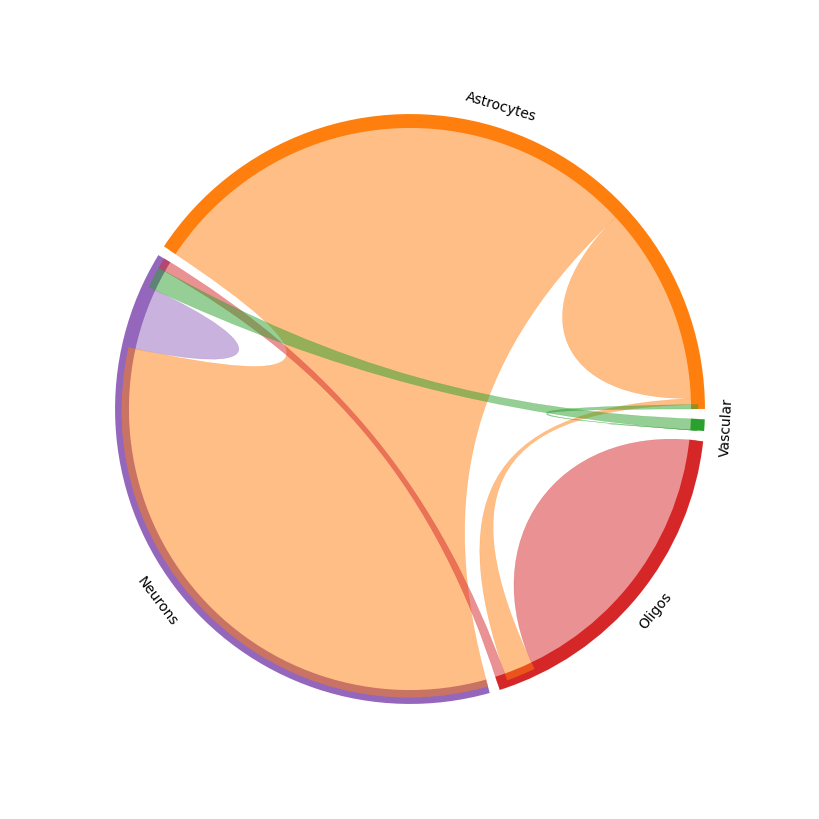

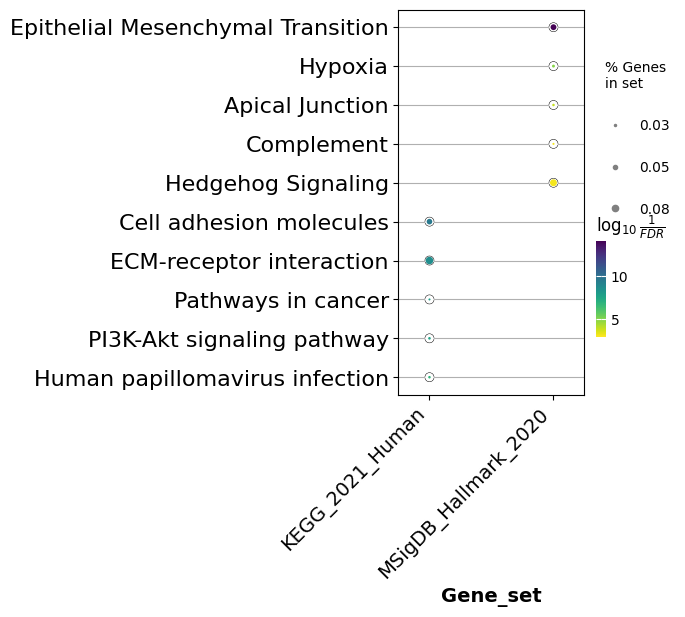

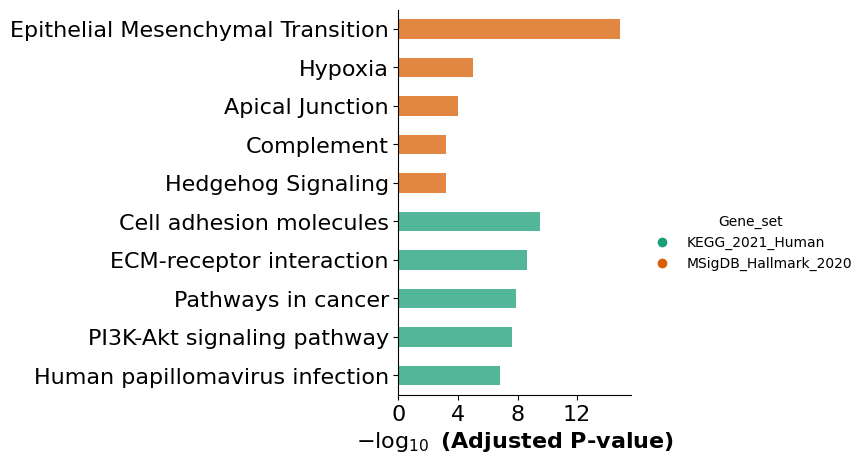

In [19]:
aged_clusters = mmcci.an.lr_grouping(aged_integrated_filtered, n_clusters=0)
aged_integrated_clusters = mmcci.an.subset_clusters(aged_integrated_filtered, aged_clusters)
aged_overall_clusters = mmcci.an.calculate_cluster_interactions(aged_integrated_clusters)

for cluster, matrix in list(aged_overall_clusters.items())[0:1]:
    print("\ncluster" + str(cluster) + ": Contains " + str(len(aged_integrated_clusters[cluster])) + " LR pairs")
    mmcci.plt.chord_plot(matrix, colors=colors)
    mmcci.an.run_gsea(aged_integrated_clusters[cluster], organism="mouse", gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"])

Computing Dissimilarity Scores for multiple interactions...


Processing: 100%|██████████| 168/168 [00:07<00:00, 21.54it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...
Computing Dissimilarity Scores for single interactions...


Processing: 100%|██████████| 255/255 [00:19<00:00, 13.29it/s]


Computing Principal Components of weighted graph ...
Performing Clustering and Ranking within clusters...

cluster0: Contains 53 LR pairs


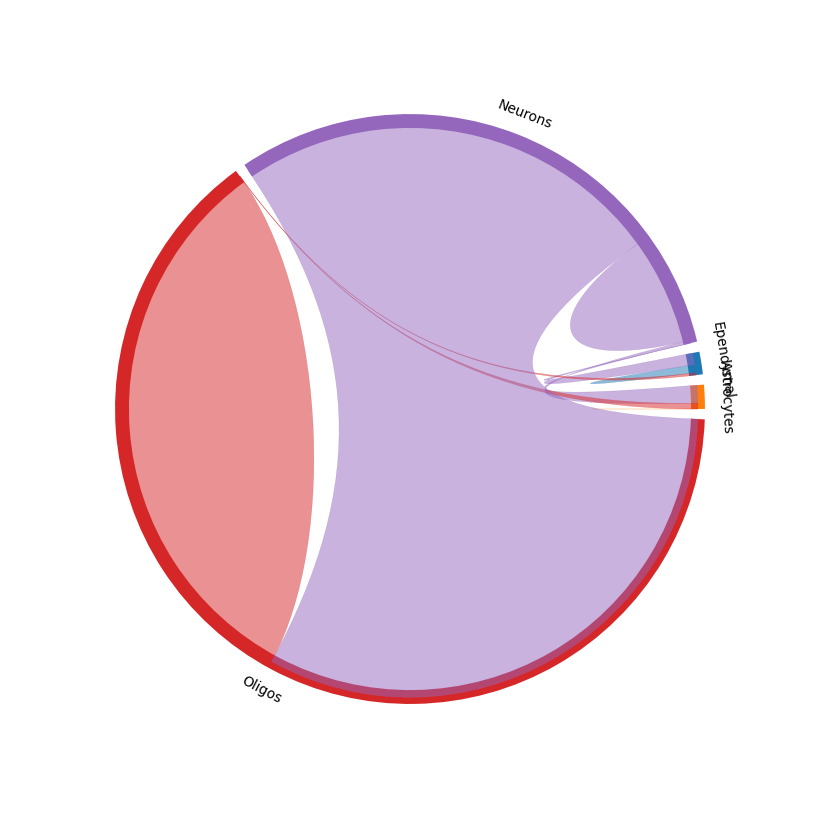

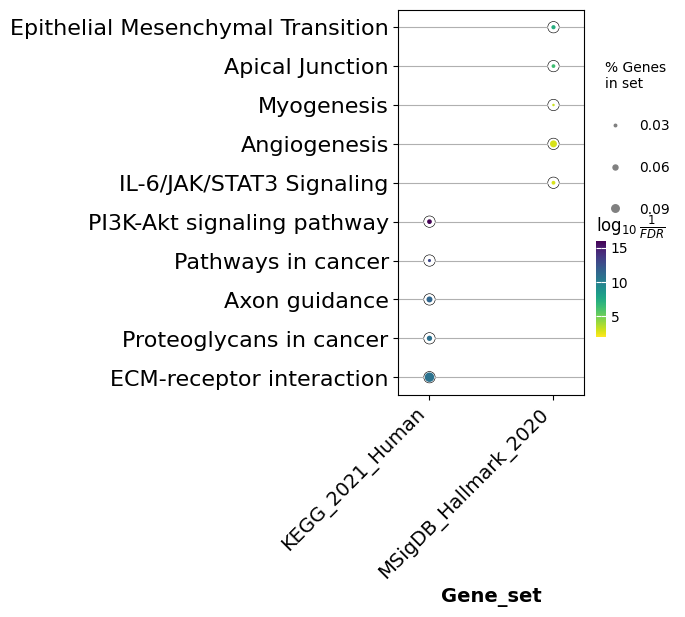

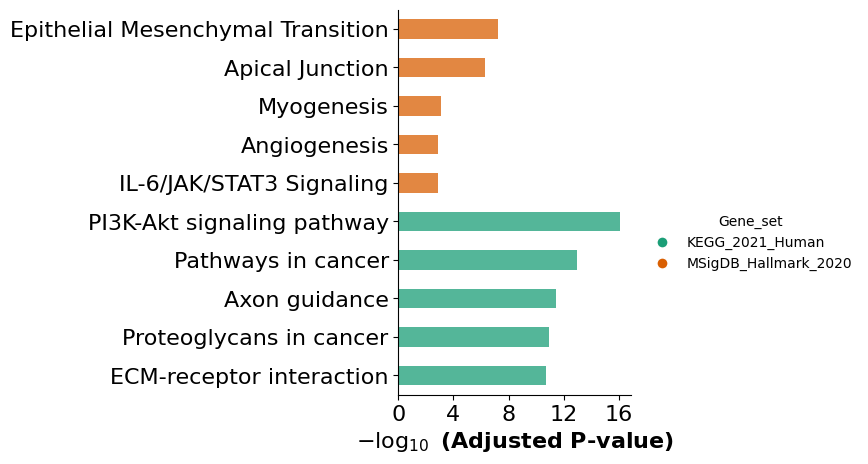

In [20]:
young_clusters = mmcci.an.lr_grouping(young_integrated_filtered, n_clusters=0)
young_integrated_clusters = mmcci.an.subset_clusters(young_integrated_filtered, young_clusters)
young_overall_clusters = mmcci.an.calculate_cluster_interactions(young_integrated_clusters)
        
for cluster, matrix in list(young_overall_clusters.items())[0:1]:
    print("\ncluster" + str(cluster) + ": Contains " + str(len(young_integrated_clusters[cluster])) + " LR pairs")
    mmcci.plt.chord_plot(matrix, colors=colors)
    mmcci.an.run_gsea(young_integrated_clusters[cluster], organism="mouse", gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"])

#### 5. Run interaction pathway analysis

This analysis clusters LR pairs that are part of a GSEA pathway \
Here we show an example of the complement pathway in the aged integrated sample

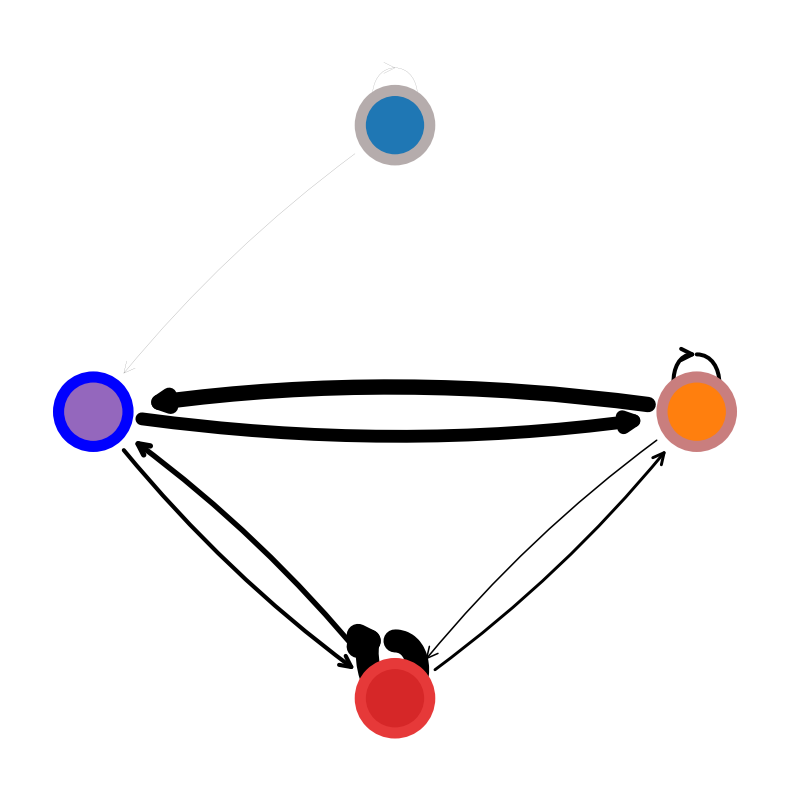

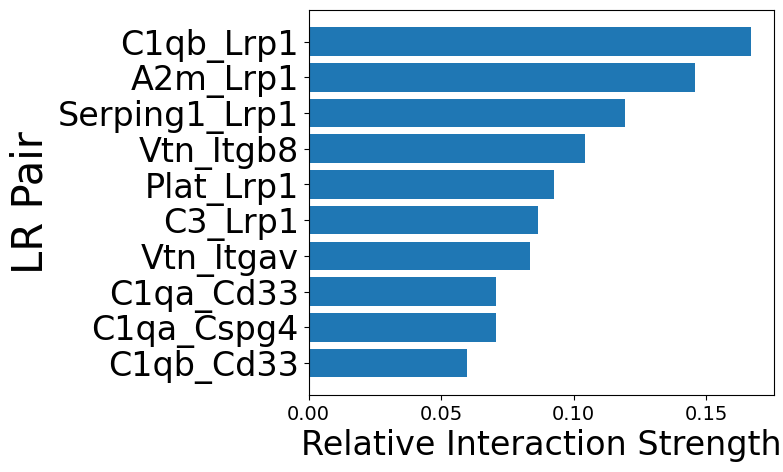

In [21]:
# First we run the pathway analysis to find the LR pairs involved in each pathway
results = mmcci.an.run_gsea(aged_integrated_filtered, organism="mouse", gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"], show_plots=False)

# We subset the LR pairs to only include those involved in the Complement and coagulation cascades pathway
grouped = mmcci.an.pathway_subset(aged_integrated_filtered, results, ["Complement and coagulation cascades"], strict=False)
grouped_overall = mmcci.it.calculate_overall_interactions(grouped)
mmcci.plt.network_plot(grouped_overall, node_size=2500, edge_weight=50, figsize=(8,8), node_colors=colors, show_labels=False)
mmcci.plt.lr_barplot(grouped, n=10, x_label_size=24, y_label_size=30, y_tick_size=24, figsize=(6,5))

#### 6. Run LR interaction clustering

This analysis requires an AnnData sample that has been processed through stLearn as input. It will cluster spots together with similar LR interaction scores.
Here we show an example one sample (not included in data files).

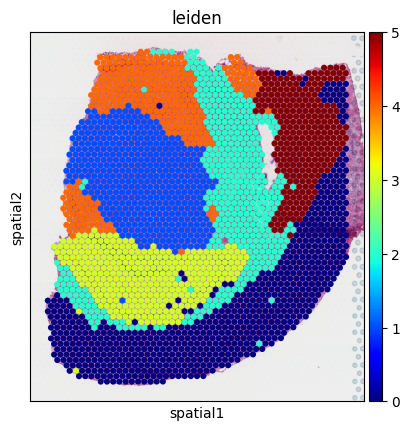

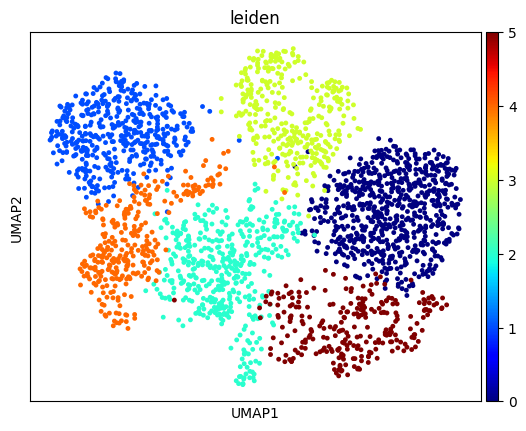

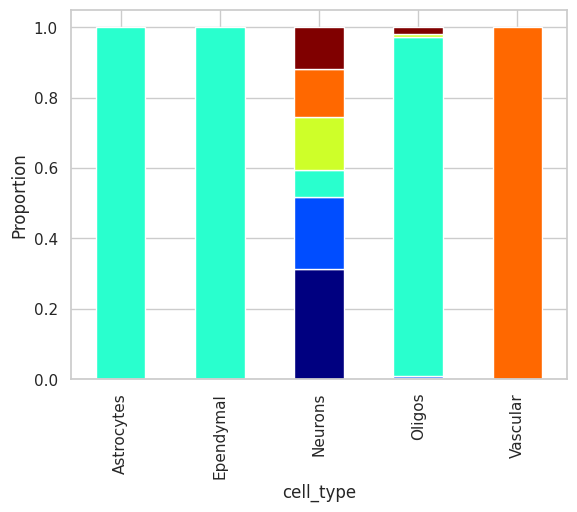

In [20]:
mmcci.an.lr_interaction_clustering(brain_anndata_sample, clustering="leiden")